<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/car_track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

In [2]:
def _atleast2d(*args):
    return tuple(jnp.atleast_2d(elem) for elem in args)

In [3]:
def generate_ssm_naive(key, m_0, A, Q, H, R, steps):
    m_0 = jnp.atleast_1d(m_0)
    A, Q, H, R = _atleast2d(A, Q, H, R)
    
    M, N = m_0.shape[-1], R.shape[-1]
    states = []
    observations = []

    state = m_0
    for i in range(steps):
        key, rng = jr.split(key)
        state = A @ state + jr.multivariate_normal(rng, jnp.zeros(M), Q, method='cholesky')
        states.append(state)
        obs = H @ state + jr.multivariate_normal(rng, jnp.zeros(N), R, method='cholesky')
        observations.append(obs)
    
    return states, observations

In [4]:
def generate_ssm(key, m_0, A, Q, H, R, steps):
    def _step(carry, rng_and_t):
        state = carry
        rng, t = rng_and_t
        rng1, rng2 = jr.split(rng, 2)
        next_state = A @ state + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        observation = H @ state + jr.multivariate_normal(rng2, jnp.zeros(N), R)
        return next_state, (state, observation)
    m_0 = jnp.atleast_1d(m_0)
    A, Q, H, R = _atleast2d(A, Q, H, R)
    M, N = m_0.shape[-1], R.shape[-1]

    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, (rngs, jnp.arange(steps))
    )
    return states, observations

In [5]:
M, N = 2, 1
m_0 = jnp.zeros(M)
P_0 = Q = jnp.array([[0.4, -0.2],
                     [-0.2, 0.5]])
A = jnp.zeros((M, M))
H = [0., 0.]
R = 0.5
key = jr.PRNGKey(0)

In [21]:
%%time
states, observations = generate_ssm_naive(key, m_0, A, Q, H, R, 100000)

CPU times: user 1min, sys: 295 ms, total: 1min
Wall time: 1min 1s


In [24]:
%%time
states, observations = generate_ssm(key, m_0, A, Q, H, R, 100000)

CPU times: user 5.25 s, sys: 193 ms, total: 5.44 s
Wall time: 5.23 s


In [11]:
# Plot timed results against different step sizes
import numpy as np
import time

key = jr.PRNGKey(0)
step_grid = np.arange(0, 10000, 200)

naive_times, lax_times = [], []
for step_size in step_grid:
    start = time.time()
    _ = generate_ssm_naive(key, m_0, A, Q, H, R, step_size)
    naive_time = time.time()-start
    naive_times.append(naive_time)
    start = time.time()
    _ = generate_ssm(key, m_0, A, Q, H, R, step_size)
    lax_time = time.time()-start
    lax_times.append(lax_time)
    if ((step_size%1000) == 0):
        print("current step size = ", step_size)
        print("naive approach took ", naive_time, " seconds.")
        print("lax scan approach took ", lax_time, " seconds.")

current step size =  0
naive approach took  0.0007956027984619141  seconds.
lax scan approach took  0.5086143016815186  seconds.
current step size =  1000
naive approach took  0.6456422805786133  seconds.
lax scan approach took  0.9431383609771729  seconds.
current step size =  2000
naive approach took  1.332261562347412  seconds.
lax scan approach took  1.0399634838104248  seconds.
current step size =  3000
naive approach took  1.9527490139007568  seconds.
lax scan approach took  0.9888734817504883  seconds.
current step size =  4000
naive approach took  2.603656530380249  seconds.
lax scan approach took  0.9959025382995605  seconds.
current step size =  5000
naive approach took  3.3379099369049072  seconds.
lax scan approach took  0.9496066570281982  seconds.
current step size =  6000
naive approach took  3.900109052658081  seconds.
lax scan approach took  0.8973994255065918  seconds.
current step size =  7000
naive approach took  4.601067066192627  seconds.
lax scan approach took  1

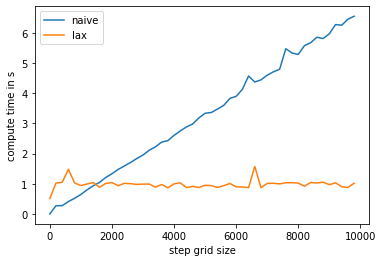

In [12]:
# Plot the result
plt.figure()
plt.plot(step_grid, naive_times, label='naive')
plt.plot(step_grid, lax_times, label='lax')
plt.xlabel('step grid size')
plt.ylabel('compute time in s')
plt.legend();
plt.show()

In [21]:
def plot_car_trajectory(y, x1, label1, x2=None, label2=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y[:, 0], y[:, 1], marker="o", label="Measurements", color="red")
    ax.plot(x1[:, 0], x1[:, 1], label=label1, color="blue")
    if x2 is None:
        ax.scatter(x1[0, 0], x1[0, 1], marker="x", color="orange", s=500)
    else:
        ax.plot(x2[:, 0], x2[:, 1], label=label2, color="orange")
    _ = ax.legend()
    _ = ax.set_xlabel("${\it x}_1$")
    _ = ax.set_ylabel("${\it y}_1$")

In [13]:
q = 1.
dt = 0.1
s = 0.5

M = 4  # State dimension
N = 2  # Observation dimension

In [14]:

A = jnp.array([[1, 0, dt, 0],
               [0, 1, 0, dt],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

In [15]:
Q = q * jnp.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                   [0, dt **3 / 3, 0, dt ** 2 / 2],
                   [dt ** 2 / 2, 0, dt, 0],
                   [0, dt ** 2 / 2, 0, dt]])

In [16]:
H = jnp.array([[1, 0, 0, 0],
               [0, 1, 0, 0]])

In [17]:
R = jnp.array([[s ** 2, 0],
               [0, s ** 2]])

In [18]:
x_0 = np.array([0., 0., 1., -1.])

In [23]:
steps = 100
key = jr.PRNGKey(1)

states, observations = generate_ssm(key, x_0, A, Q, H, R, steps)

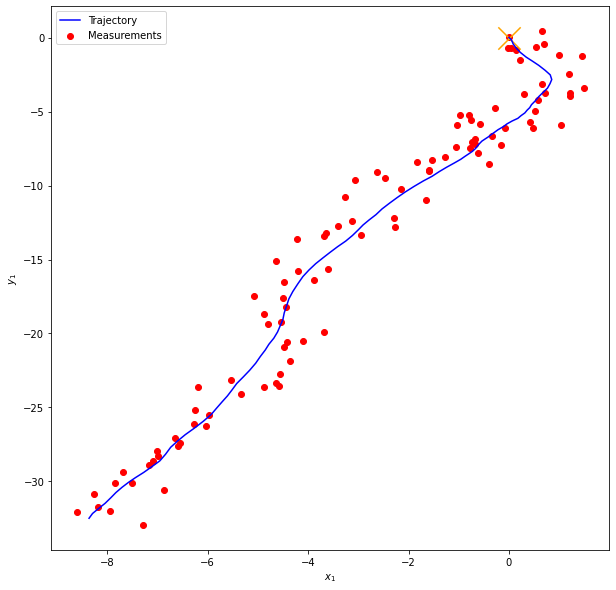

In [24]:
plot_car_trajectory(observations, states, "Trajectory")